# Assignment 3: Continuous Latent Variable Models


STATS305C, Stanford University, Spring 2022

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slinderman/stats305c/blob/master/assignments/hw3/hw3.ipynb)


---

**Name:** 
Isaac

**Collaborators:** 
Saskia C., Muhammed C.

---

This homework explores continuous latent variable models like PCA and factor analysis. We will work with a synthetic dataset (MNIST digits) where we artificially mask out some pixels. Then we'll see how well we can reconstruct the images by performing Bayesian inference in a factor analysis model with missing data.

This application may seem a bit contrived -- who cares about MNIST digits? -- but it has real-world applications. For example, [Markowitz et al (2018)](https://www.sciencedirect.com/science/article/pii/S0092867418305129) used this technique to find a low-dimensional embedding of images of partially occluded mice. 

Along the way, we'll build some intuition for PCA, hone our Gibbs sampling skills, and as a bonus, you can learn about multivariate Gaussian distribution for matrices called the matrix normal distribution.


# Setup: Imports, Helper Functions, Data Preparation


In [1]:
import torch
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms

from torch.distributions import Gamma, Normal, Bernoulli, MultivariateNormal, \
    TransformedDistribution
from torch.distributions.transforms import PowerTransform

from tqdm.auto import trange

import matplotlib.pyplot as plt
from matplotlib.cm import Blues
import seaborn as sns
sns.set_context("notebook")

class ScaledInvChiSq(TransformedDistribution):
    """
    Implementation of the scaled inverse \chi^2 distribution defined in class.
    We will implement it as a transformation of a gamma distribution.
    """
    def __init__(self, dof, scale):
        base = Gamma(dof / 2, dof * scale / 2)
        transforms = [PowerTransform(-1)]
        TransformedDistribution.__init__(self, base, transforms)
        self.dof = dof
        self.scale = scale

## Download the MNIST dataset

In [2]:
# Download MNIST training data and convert to float32
# Only use a subset of the images
N = 10000
X3d_true = MNIST(root='.', train=True, transform=None, download=True).data
X3d_true = X3d_true.type(torch.float32)
X3d_true = X3d_true[:N]
_, H, W = X3d_true.shape

# Add some noise to the images so they are not strictly integers
# Otherwise we get weird numerical bugs in the Gibbs sampling code!
torch.manual_seed(305)
X3d_true += Normal(0, 3).sample(X3d_true.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Write simple functions to mask off some of the data 

We'll make three types of masks:
- Lines through the center of the image
- Circles of random radius
- Speckle, where each pixel is missing at random

In [3]:
def random_line_mask(num_samples, 
                     mask_size=(28, 28), 
                     lw=2):
    """
    Make a mask from a line through the center of the image.

    Args:
        num_samples: number of masks to generate
        mask_size: pixels by pixels
        lw: line width in pixels

    Returns:
        masks: (num_samples,) + mask_size array of binary masks

    """
    # Sample random orientations for each line
    us = Normal(0, 1).sample((num_samples, 2))
    us /= torch.norm(us, dim=1, keepdim=True)

    # Get distance of each xy coordinate to the line
    # this is the norm of (x, y) - (xp, yph) where (xp, yp)
    # is the projection onto the line
    X, Y = torch.meshgrid(torch.arange(mask_size[0]), 
                          torch.arange(mask_size[1]))
    xy = torch.column_stack([X.ravel(), Y.ravel()])
    xy = xy - torch.tensor(mask_size) / 2.0
    
    # Project onto the line
    # xpyp.shape == (num_samples, num_points, 2)
    xpyp = (us @ xy.T).unsqueeze(2) * us.unsqueeze(1)  
    dist = torch.norm(xy - xpyp, dim=2)

    # Make masks based on a distance threshold
    return (dist < lw).reshape((num_samples,) + mask_size)
    

def random_circle_mask(num_samples, 
                       mask_size=(28, 28),
                       std_origin=3.0,
                       mean_radius=3.0,
                       df_radius=7.0):
    """
    Sample random circular masks.

    Args:
        num_samples: number of masks to generate
        mask_size: mask size in pixels
        std_origin: standard deviation of the origin in pixels
        mean_radius: mean radius of the circular masks
        df_radius: degrees of freedom of a chi^2 distribution on radii.

    Returns:
        masks: (num_samples,) + mask_size array of binary masks
    """
    centers = Normal(0, std_origin).sample((num_samples, 2))
    radii = 0.1 + Gamma(df_radius / 2,
                      df_radius / mean_radius / 2.0).sample((num_samples,))

    # Determine whether each point is inside the corresponding circle
    X, Y = torch.meshgrid(torch.arange(mask_size[0]),
                          torch.arange(mask_size[1]))
    X = X - mask_size[0] / 2.0
    Y = Y - mask_size[1] / 2.0
    xy = torch.column_stack([X.ravel(), Y.ravel()]) # (num_points, 2)
    dist = torch.norm(centers.unsqueeze(1) - xy, dim = 2)
    return  (dist < radii.unsqueeze(1)).reshape((num_samples,) + mask_size)


def random_speckle_mask(num_samples,
                        mask_size=(28, 28),
                        p_missing=0.1):
    """
    Sample a random speckle mask where each pissing is missing with equal 
    probability.

    Args:
        num_samples: number of masks to sample
        p_speckle: probability that a pixel is missing

    Returns:
        masks: (num_samples,) + mask_size binary array
    """
    masks = Bernoulli(p_missing).sample((num_samples,) + mask_size)
    return masks.type(torch.BoolTensor)

## Make masks and apply them to each data point

In [4]:
# Make masks for each data point
torch.manual_seed(305)
line_masks = random_line_mask(N // 3)
circ_masks = random_circle_mask(N // 3)
spck_masks = random_speckle_mask(N - len(line_masks) - len(circ_masks))
mask3d = torch.cat([line_masks, circ_masks, spck_masks])[torch.randperm(N)]

# Make the training data by substituting 255 (the max value of a uint8) 
# for each missing pixel
X3d = torch.clone(X3d_true)
X3d[mask3d] = 255.0

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Plot the masks and the masked data

Text(0.5, 0.98, 'Random Masks')

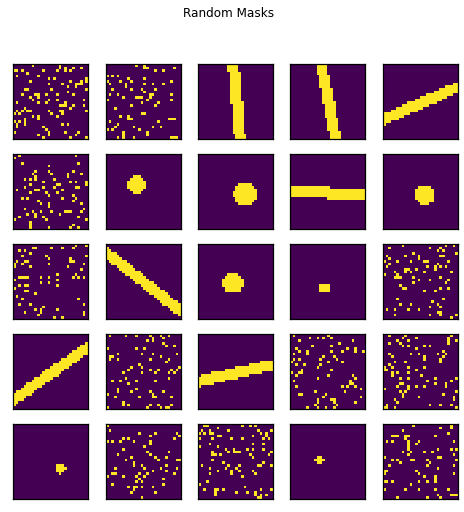

In [5]:
# Plot a few masks
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(mask3d[i * 5 + j], interpolation="none")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.suptitle("Random Masks")

Text(0.5, 0.98, 'Masked Data')

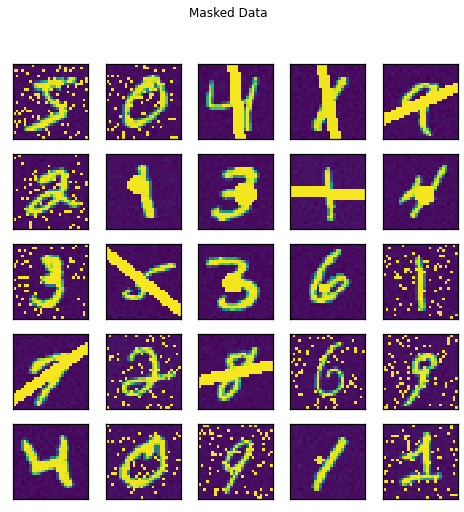

In [6]:
# Plot a few masked data points
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(X3d[i * 5 + j], interpolation="none")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.suptitle("Masked Data")

## Flatten the data and masks into 2D tensors

The masked data is now stored in the tensor `X3d`, which has shape `(60000, 28, 28)`. We will flatten the tensor into `X`, which has shape `(60000, 784)`, and consider each row to be a vector-valued observation. We'll do the same for the masks.

In [7]:
X_true = X3d_true.reshape((N, -1))
X = X3d.reshape((N, -1))
mask = mask3d.reshape((N, -1))

**Note:** From here on out, you should only need `X` and `mask` in your code algorithm. `X_true` is reserved for validation purposes. 

# Part 1: Principal Components Analysis and the SVD


## Problem 1a [Code]: Run PCA on directly on the masked data

In this problem, you'll investigate what happens if you run PCA on `X` directly.  

Implement PCA by taking the SVD of the centered and rescaled data matrix. Plot the first 25 principal components.

In [8]:
def pca(X):
    """
    Compute the principal components and the fraction of variance explained 
    using the SVD of the scaled and centered data matrix. 

    Args:
        X: a shape (N, D) tensor

    Returns:
        pcs: a shape (D, D) tensor whose columns are the full set of D principal
            components. This matrix should be orthogonal.

        var_explained: a shape (D,) tensor whose entries are the variance 
            explained by each corresponding principal component.
    """
    ## 
    # Your code below.
    #
    ##
    _, S, VH = torch.linalg.svd(X) # pcs = VH.T
    pcs = VH.T
    var_explained = torch.pow(S, 2) / torch.sum(torch.pow(S, 2))
    # assert pcs.T @ pcs == torch.eye(X.shape[1])
    return pcs, var_explained

We have provided some code below to run your code and plot the results.

In [9]:
def plot_pca(pcs, var_explained):
    """
    Helper function to plot the principal components and the variance explained,
    aka scree plot.
    """
    # Plot the first 25 principal components
    fig, axs = plt.subplots(5, 5, figsize=(8, 8))
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(pcs[:, i * 5 + j].reshape((28, 28)), 
                            interpolation="none")
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].set_title("PC {}".format(i * 5 + j + 1))
    plt.tight_layout()

    # Make the scree plot
    plt.figure()
    plt.plot(torch.cumsum(var_explained, dim=0))
    plt.xlabel("Number of PCs")
    plt.xlim(0, 784)
    plt.ylabel("Fraction of Variance Explained")
    plt.ylim(0, 1)
    plt.grid(True)

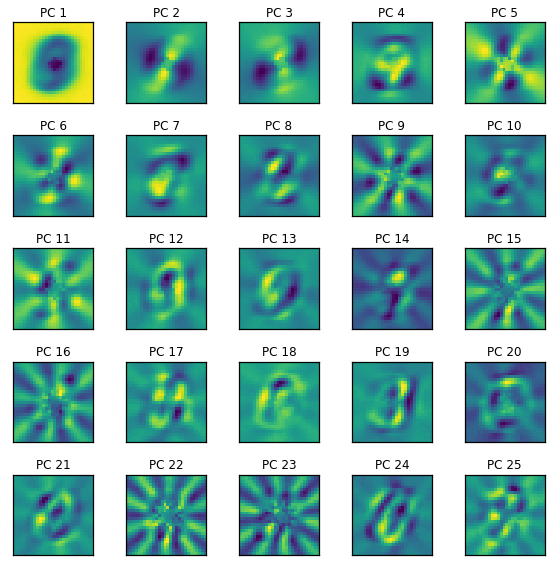

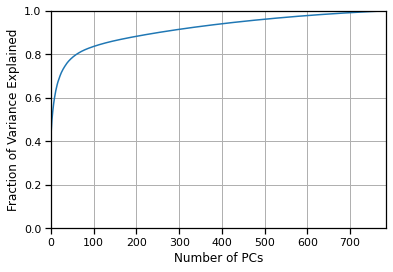

In [10]:
# Plot the pca results for X, the flattened, masked data
plot_pca(*pca(X))

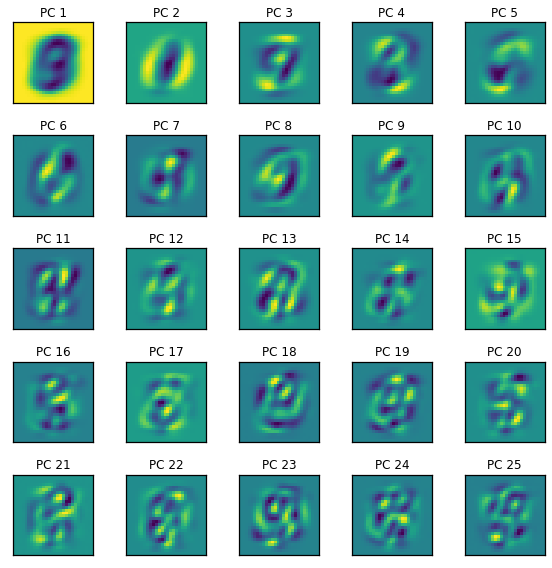

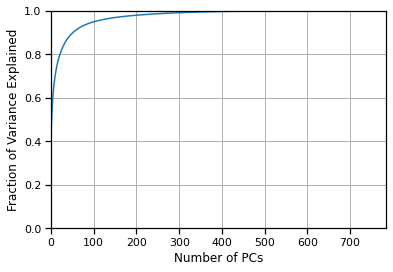

In [11]:
# Compare the results to PCA on the X_true, the flattened true data
plot_pca(*pca(X_true))

## Problem 1b [Short Answer]: Why does PCA on the masked data need so many more components?

PCA needs far fewer components to reach 90% variance explained on the real data (`X_true`) than it does on the masked data (`X`). Intuitively, why is that?


---

Here, the masking impacts the downstream PCAs: that is, we impute according to whatever schema (i.e. reverting random points to the 255 value), which in turn affects/distorts the SVD. As such, there's more garbage to cut through when doing the SVD/PCA, which likely results in less mileage per component. 

Furthermore, the imputation procedure of knocking random points to 255 also introduces a data structure that is not readily compatible with PCA. Recall that PCA presumes that the data can be linearly represented in some lower-dimensional setting. The imputation here breaks that linearity (as you're just throwing in outliers onto the fringes), causing data to no longer live in a linear subspace -- again, to the detriment of any PCA attempt.


---

# Part 2: Gibbs Sampling for Factor Analysis with Missing Data

Now we will try to fit a continuous latent variable model to the masked data by treating the masked pixels as missing data. As in lecture, we will assume a conjugate prior of the form,
\begin{align}
\sigma_d^2 &\sim \chi^{-2}(\nu_0, \sigma_0^2) \\
\mathbf{w}_d &\sim \mathcal{N}(\mathbf{0}, \tfrac{\sigma_d^2}{\kappa_0} \mathbf{I}) \\
\mu_d &\sim \mathcal{N}(0, \tfrac{\sigma_d^2}{\lambda_0})
\end{align}
The only thing we've added is a prior on the mean, which we previously assumed to be fixed at zero.

Given the parameters, the distribution on latent variables and data is,
\begin{align}
\mathbf{z}_n &\sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\
\mathbf{x}_n &\sim \mathcal{N}(\mathbf{W} \mathbf{z}_n + \boldsymbol{\mu}, \mathrm{diag}(\boldsymbol{\sigma}^2))
\end{align}
where $\mathbf{W} \in \mathbb{R}^{D \times M}$ is a matrix with rows $\mathbf{w}_d$, $\boldsymbol{\mu} = [\mu_1, \ldots, \mu_D]^\top$ and $\boldsymbol{\sigma}^2 = [\sigma_1^2, \ldots, \sigma_D^2]^\top$.

The graphical model (omitting the hyperparameters) looks like this:

<img src="https://dl.dropbox.com/s/xwojsl2jfkolxj3/fa_missing_data2.png?dl=0" alt="Factor Analysis with Missing Data Graphical Model" width="600"/>

<!-- ![Factor Analysis with Missing Data Graphical Model](https://dl.dropbox.com/s/zcqu0ddvx5ca5h1/fa_missing_data.png?dl=0) -->


Here, the $d$th coordinate is missing from the $n$-th data point. On other data points, other subsets of coordinates may be missing.


To formalize the problem, let
\begin{align}
\mathbf{X}_{\mathsf{obs}} &= \{x_{n,d}: x_{n,d} \text{ is observed}\} \\
\mathbf{X}_{\mathsf{miss}} &= \{x_{n,d}: x_{n,d} \text{ is missing}\}
\end{align}
denote the observed and missing data, respectively. 

**Our goal** is to infer the posterior distribution over parameters and latent variables and _missing_ data given only the _observed_ data and hyperparamters,
\begin{align}
p(\mathbf{W}, \boldsymbol{\mu}, \boldsymbol{\sigma^2}, \mathbf{Z}, \mathbf{X}_{\mathsf{miss}} \mid \mathbf{X}_{\mathsf{obs}}, \boldsymbol{\eta}),
\end{align}
where $\boldsymbol{\eta} = (\nu_0, \sigma_0^2, \kappa_0, \lambda_0)$ are the hyperparameters.

To do so, we will implement a Gibbs sampling algorithm that alternates between updating the parameters $\mathbf{W}$ and $\boldsymbol{\sigma^2}$ and the latent variables $\mathbf{z}_n$ for each data point, and then we'll add one more step: sampling new values for the missing data $\mathbf{X}_{\mathsf{miss}}$ from their conditional distribution. With samples of $\mathbf{X}_{\mathsf{miss}}$, for example, we can approximate the posterior distribution over the masked regions of the image. 

<!-- **Finally**, to compute the posterior over just the weights, variance, and latent variables, 
\begin{align}
p(\mathbf{W}, \boldsymbol{\sigma^2}, \mathbf{Z} \mid \mathbf{X}_{\mathsf{obs}}).
\end{align}
note that this is just a marginal of the distribution above.
So if we had a Gibbs sampler that (asymptotically) gave us samples,
\begin{align}
\mathbf{W}^{(s)}, {\boldsymbol{\sigma}^2}^{(s)}, \mathbf{Z}^{(s)}, \mathbf{X}_{\mathsf{miss}}^{(s)} \sim 
p(\mathbf{W}, \boldsymbol{\sigma^2}, \mathbf{Z}, \mathbf{X}_{\mathsf{miss}} \mid \mathbf{X}_{\mathsf{obs}})
\end{align}
then we could literally just throw away $\mathbf{X}_{\mathsf{miss}}^{(s)}$ to get 
\begin{align}
\mathbf{W}^{(s)}, {\boldsymbol{\sigma}^2}^{(s)}, \mathbf{Z}^{(s)} \sim 
p(\mathbf{W}, \boldsymbol{\sigma^2}, \mathbf{Z} \mid \mathbf{X}_{\mathsf{obs}})
\end{align}

This trick is called **data augmentation**.  -->

## Problem 2a [Math]: Derive the complete conditional distributions for the Gibbs sampler

Specifically, derive closed form expressions for the following conditional distributions:
- $p(\mathbf{w_d} \mid \{\mathbf{w}_i\}_{i \neq d}, \boldsymbol{\mu}, \boldsymbol{\sigma}^2, \mathbf{Z}, \mathbf{X}_{\mathsf{miss}}, \mathbf{X}_{\mathsf{obs}}, \boldsymbol{\eta})$
- $p(\mu_d \mid \{\mu_i\}_{i \neq d}, \mathbf{W}, \boldsymbol{\sigma}^2, \mathbf{Z}, \mathbf{X}_{\mathsf{miss}}, \mathbf{X}_{\mathsf{obs}}, \boldsymbol{\eta})$
- $p(\sigma_d^2 \mid \{\sigma_i^2\}_{i \neq d}, \mathbf{W}, \boldsymbol{\mu}, \mathbf{Z}, \mathbf{X}_{\mathsf{miss}}, \mathbf{X}_{\mathsf{obs}}, \boldsymbol{\eta})$
- $p(\mathbf{z}_n \mid \mathbf{W}, \boldsymbol{\mu}, \boldsymbol{\sigma}^2, \{\mathbf{z}_i\}_{i\neq n}, \mathbf{X}_{\mathsf{miss}}, \mathbf{X}_{\mathsf{obs}}, \boldsymbol{\eta})$
- $p(x_{n,d} \mid \mathbf{W}, \boldsymbol{\mu}, \boldsymbol{\sigma}^2, \mathbf{Z}, \mathbf{X}_{\mathsf{obs}}, \boldsymbol{\eta})$  for each missing entry $x_{n,d}$

_Hint: Your expressions may not depend on all of the conditioned upon variables._



---

It maybe helpful to begin with a complete joint-likelihood, i.e.

\begin{align*}
\mathcal{L}(\cdot)
&= \bigg(\prod_{n=1}^N \mathcal{N}(x_n | Wz_n + \mu, diag(\sigma^2) )
\cdot \mathcal{N}(z_n|0, I_M) \bigg) \\
&\hspace{1.5cm}
\bigg(\prod_{d=1}^D \mathcal{N}\left (w_d | 0, \frac{\sigma_d^2}{k_0} I_m\right) 
\cdot \mathcal{N}(\mu_d|0, \sigma^2_d / \lambda_0) 
\cdot \chi^{-2}(\eta_0, \sigma_0^2)
\bigg) \\
% full expansion
&= \bigg(\prod_{n=1}^N \prod_{d=1}^D \mathcal{N}(x_{n, d} | w_d^Tz_n + \mu_d, \sigma_d^2 )
\cdot \mathcal{N}(z_{n, d}|0, 1) \bigg) \\
&\hspace{1.5cm}
\bigg(\prod_{d=1}^D \mathcal{N}\left (w_d | 0, \frac{\sigma_d^2}{k_0} I_m\right) 
\cdot \mathcal{N}(\mu_d|0, \sigma^2_d / \lambda_0) 
\cdot \chi^{-2}(\sigma^2_d | \eta_0, \sigma_0^2)
\bigg)
\end{align*}

---

#### **i.)**
Dropping constants (i.e. things not involving a $w_d$), we have 
\begin{align*}
p(w_d | -)
&\propto \mathcal{L}(\cdot) \\
&\propto 
\bigg(\prod_{n=1}^N \mathcal{N}(x_{n, d} | w_d^Tz_n + \mu_d, \sigma_d^2 )
\bigg)
\mathcal{N}\left (w_d | 0, \frac{\sigma_d^2}{k_0} I_m\right) \\
&\propto 
\bigg(\prod_{n=1}^N \mathcal{N}(x_{n, d} - \mu_d | w_d^Tz_n, \sigma_d^2 )
\bigg)
\mathcal{N}\left (w_d | 0, \frac{\sigma_d^2}{k_0} I_m\right) .
\end{align*}
At this point, we really just have a Bayesian linear regression, where 
$$Z = \begin{bmatrix}z_1^T\\\vdots\\z_N^T\end{bmatrix},$$
is the design, $w_d$ are our weights, and $X_{\cdot, d} - \mu_d$ is a response vector (where we've assumed to have vectorized $\mu_d$). Hence, from HW1 and more generally the normal-normal conjugacy, we have
$$
\Lambda_{w_d} = \sigma_d^{-2}Z^TZ + \frac{k_0}{\sigma_d^2}I_M
=
\frac{1}{\sigma_d^2}\bigg(Z^TZ + k_0 I_M\bigg)
$$
and 
$$
m_{w_d} = \Lambda_{w_d}^{-1}(k_0 \sigma_d^{-2}0^T I_m + \sigma_d^{-2}Z^T(X_{\cdot, d} - \mu_d)
= \Lambda_{w_d}^{-1}(\sigma_d^{-2}Z^T(X_{\cdot, d} - \mu_d)).
$$


*Importantly, note that the $\sigma_d^2$ term is absorbed into the posterior covariance, unlike in the Bayesian OLS setting from HW1. This is because in HW1, we were dealing with a separate Normal-Inverse-Gamma parameterization, where said $\sigma_d^2$ was treated as a separate parameter that was eventually multiplied to the covariance in the normal portion of the Normal-Inverse-Gamma. However here, we are just using normals, so the $\sigma_d^2$ cannot be treated as a model parameter, and is thus absorbed in the covariance.*


Conveniently, we can cancel out a $\sigma_d^2$, i.e.
$$
m_{w_d} = \underbrace{\sigma_d^2\bigg(Z^TZ + k_0 I_M\bigg)^{-1}}_{\Lambda_{w_d}^{-1}} (\sigma_d^{-2}Z^T(X_{\cdot, d} - \mu_d))
=
(Z^TZ + k_0 I_M)^{-1}Z^T(X_{\cdot, d} - \mu_d).
$$
This saves us an extra dimension during torch-ing.

#### **ii.)** 
Again, we have

\begin{align*}
p(\mu_d | - ) 
&\propto 
\mathcal{L}(\cdot) \\
&\propto 
\bigg(\prod_{n=1}^N \mathcal{N}(x_{n, d} | w_d^Tz_n + \mu_d, \sigma_d^2 )\bigg) \cdot 
\mathcal{N}(\mu_d|0, \sigma^2_d / \lambda_0)  \\
&\propto 
\bigg(\prod_{n=1}^N \mathcal{N}(x_{n, d} - w_d^Tz_n| \mu_d, \sigma_d^2 )\bigg) \cdot \mathcal{N}(\mu_d|0, \sigma^2_d / \lambda_0).
\end{align*}
Now, we have a run-of-the-mill [normal-normal conjugacy](https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_continuous_distribution):
$$
\phi_{\mu_d} = \frac{\lambda_0}{\sigma_d^2} + \frac{N}{\sigma^2_d}
= \frac{\lambda_0 + N }{\sigma_d^2}
$$
and
$$
m_{\mu_d} = \phi_{\mu_d}^{-1}
\bigg[\frac{\lambda_0 \cdot 0}{\sigma^2_d} + \frac{1}{\sigma_d^2}\sum_{n=1}^N x_{n, d} - w_d^Tz_n
\bigg]
=
\phi_{\mu_d}^{-1}
\bigg[\frac{1}{\sigma_d^2}\sum_{n=1}^N x_{n, d} - w_d^Tz_n
\bigg].
$$

#### **iii.)**
 For variance, we have (using a simple linear reparameterization to rid of the $k_0, \lambda_0$ denominators)
\begin{align*}
p(\sigma_d^2 | -) 
&\propto 
\mathcal{L}(\cdot) \\
&\propto 
\bigg(\prod_{n=1}^N \prod_{d=1}^D \mathcal{N}(x_{n, d} | w_d^Tz_n + \mu_d, \sigma_d^2 )
\cdot \mathcal{N}(z_{n, d}|0, 1) \bigg) \\
&\hspace{1.5cm}
\bigg(\prod_{d=1}^D \mathcal{N}\left (w_d | 0, \frac{\sigma_d^2}{k_0} I_m\right) 
\cdot \mathcal{N}(\mu_d|0, \sigma^2_d / \lambda_0) 
\cdot \chi^{-2}(\sigma^2_d | \eta_0, \sigma_0^2)
\bigg) \\
&\propto 
\bigg(\prod_{n=1}^N \mathcal{N}(x_{n, d} | w_d^Tz_n + \mu_d, \sigma_d^2 )
\bigg)
\mathcal{N}\left (w_d | 0, \frac{\sigma_d^2}{k_0} I_m\right) 
\mathcal{N}(\mu_d|0, \sigma^2_d / \lambda_0) 
\chi^{-2}(\sigma^2_d | \eta_0, \sigma_0^2)
\\
&=
\bigg(
\prod_{n=1}^N \mathcal{N}(x_{n, d} | w_d^Tz_n + \mu_d, \sigma_d^2 )
\bigg)
\mathcal{N}\left(\sqrt{k_0} w_d | 0, \sigma_d^2 I_m\right) |k_0|^{M/2}
\mathcal{N}(\sqrt{\lambda_0}\mu_d|0, \sigma^2_d )|\lambda_0|^{1/2}\cdot 
\chi^{-2}(\sigma^2_d | \eta_0, \sigma_0^2)\\
&\propto 
\bigg(
\prod_{n=1}^N \mathcal{N}(x_{n, d} | w_d^Tz_n + \mu_d, \sigma_d^2 )
\bigg)
\mathcal{N}\left(\sqrt{k_0} w_d | 0, \sigma_d^2 I_m\right)
\mathcal{N}(\sqrt{\lambda_0}\mu_d|0, \sigma^2_d )\cdot 
\chi^{-2}(\sigma^2_d | \eta_0, \sigma_0^2) \\
&\propto 
%%% normal
\bigg(
\frac{1}{\sigma^2}
\bigg)^{N/2}\exp\bigg(
-\frac{1}{2\sigma_d^2}\sum_{n=1}^N (X_{n,d} - w_d^Tz_n - \mu_d)^2
\bigg)\\&\hspace{1.5cm}
%%% weights 
\bigg(
\frac{1}{\sigma^2}
\bigg)^{M/2}\exp\bigg(
-\frac{1}{2\sigma_d^2} \sum_{m=1}^M (\sqrt{k_0}w_{d, m} - 0)^2
\bigg)\\&\hspace{1.5cm}
%%% mu
\bigg(
\frac{1}{\sigma^2}
\bigg)^{1/2}\exp\bigg(
-\frac{1}{2\sigma_d^2} (\sqrt{\lambda_0}\mu_d - 0)^2
\bigg)\\&\hspace{1.5cm}
%%% chisq
\bigg(
\frac{1}{\sigma^2}
\bigg)^{(\nu_0 - 1)/2}\exp\bigg(
-\frac{1}{2\sigma_d^2} \nu_0 \sigma_0^2
\bigg) \\
&=
(\sigma_d^2)^{-\left(\frac{N + M + 1 + \nu_0 - 1}{2}\right)}
\exp\left( 
-\frac{1}{2\sigma_d^2}\left( 
\sum_{n=1}^N (X_{n,d} - w_d^Tz_n - \mu_d)^2 + k_0\sum_{m=1}^M w_{d, m}^2 + \lambda_0 \mu_d^2 + \nu_0 \sigma_0^2.
\right)
\right)
\end{align*}
This is quite clearly the kernel of a scaled chi-squared itself, with 
$$
\nu = N + M + \nu_0 + 1 
$$
and 
$$
\sigma^2 = 
\frac{1}{N + M + \nu_0 + 1}
\left(
\sum_{n=1}^N (X_{n,d} - w_d^Tz_n - \mu_d)^2 + k_0\sum_{m=1}^M w_{d, m}^2 + \lambda_0 \mu_d^2 + \nu_0 \sigma_0^2.
\right)
$$

#### **iv.)**
 We have
\begin{align*}
p(z_n | - ) 
&\propto 
\mathcal{L}(\cdot) \\
&\propto 
\bigg(\prod_{d=1}^D \mathcal{N}(x_{n, d} | w_d^Tz_n + \mu_d, \sigma_d^2 )
\cdot \mathcal{N}(z_{n, d}|0, 1) \bigg) \\
&\propto 
\bigg(\prod_{d=1}^D \mathcal{N}(x_{n, d} - \mu_d | z_n^Tw_d, \sigma_d^2 )
\cdot \mathcal{N}(z_{n, d}|0, 1) \bigg);
\end{align*}
again, this is just a Bayesian OLS, so we see 
$$
\Lambda_{z_n} = I + W^Tdiag(\sigma^{-2})W
$$
and
$$
m_{z_n} = \Lambda_{z_n}^{-1}[0 + W^Tdiag(\sigma^{-2})(x_{n} - \mu)]. 
$$
The $\sigma^2$ is absorbed by the same justification above.

#### **v.)**
 Lastly, we have
\begin{align*}
p(x_{n, d}|-)
&\propto 
\mathcal{L}(\cdot) \\
&\propto 
\bigg(\prod_{n=1}^N \prod_{d=1}^D \mathcal{N}(x_{n, d} | w_d^Tz_n + \mu_d, \sigma_d^2 )
\cdot \mathcal{N}(z_{n, d}|0, 1) \bigg) \\
&\hspace{1.5cm}
\bigg(\prod_{d=1}^D \mathcal{N}\left (w_d | 0, \frac{\sigma_d^2}{k_0} I_m\right) 
\cdot \mathcal{N}(\mu_d|0, \sigma^2_d / \lambda_0) 
\cdot \chi^{-2}(\sigma^2_d | \eta_0, \sigma_0^2)
\bigg)\\
&\propto 
\mathcal{N}(x_{n, d} | w_d^Tz_n + \mu_d, \sigma_d^2 ),
\end{align*}
i.e. the "last-stage" likelihood component of the generative model, which makes sense. 

## Problem 2b [Short answer]: Which Gibbs steps can be performed in parallel?

As in Assignment 2, some of these updates can be performed in parallel using a blocked Gibbs udpate. Which ones?

---

As demonstrated through the use of broadcasting below, each of the above i.-v. are effectively performed as blocks. That is, each of $w_d, \mu_d, \sigma_d, X_{n, d}$, and $z_n$ are blocked, where each index in said variable is updated in parallel to one another. Such parallelization follows from the conditional independence of each variable with it's other indices (i.e. $w_j$ is conditionally independent of $w_{\ell \neq j}$ -- we see this in the DAG above, as indices w.r.t. a particular variable do not cross-pollinate, and hence conditional independence is perserved.

---

## Problem 2c [Code]: Implement the Gibbs sampler

Finish the functions below to implement the udpates you derived above. We have provided some function headers to help you organize your solutions.

In [ ]:
def log_probability(X, Z, W, mu, sigmasq, nu0, sigmasq0, kappa0, lambda0, dims):
    """
    Evaluate the log joint probability of the _complete_ data and all the 
    latent variables and parameters.

    Args:
        X: shape (N,D) tensor with the complete data (current samples of the 
            missing data are filled in)
        Z: shape (N,M) tensor with the latent variables
        W: shape (D,M) tensor of weights
        mu: shape (D,) tensor with the mean parameter
        sigmasq: shape (D,) tensor with the variance parameters
        nu0, sigmasq0: scalar hyperparameters for the prior on variance
        kappa0: scalar hyperparameter for the prior on weights
        lambda0: scalar hyperparameter for the prior on mean
        dims: tuple (N, M, D)
    """
    ###
    # Your code here.
    #
    # Hint: Take advantage of Pytorch distributions' support for broadcasting
    # to evaluate many log probabilities at once.

    # unpack
    N, M, D = dims

    ### Likelihood ###
    # components of the mean
    w_zn = Z @ W.T  # Wzn
    mu_long = mu.repeat(N, 1) # broadcast mu
    s = sigmasq.repeat(N, 1) # broadcast sigma
    # check dims
    assert w_zn.shape == mu_long.shape # check dims
    assert w_zn.shape == s.shape
    m = w_zn + mu_long # compute likelihood mean
    # log probs of these
    logp_X = Normal(
        loc=m,
        scale=torch.pow(s, 1/2)
    ).log_prob(X).sum()

    ### p(Z) ###
    logp_Z = Normal(0, 1).log_prob(Z).sum()

    ### p(mu) ###
    logp_mu = Normal(
        loc=torch.zeros(D), 
        scale=torch.pow(
            sigmasq / lambda0,
            1/2
        )
    ).log_prob(mu).sum()

    ### p(W) ###
    logp_w = MultivariateNormal(
        loc=torch.zeros_like(W.T),
        covariance_matrix=torch.diag(sigmasq / kappa0).unsqueeze(0)
    ).log_prob(W.T).sum()


    ### p(sigma2_d) ###
    logp_sigma2_d = ScaledInvChiSq(nu0, sigmasq0).log_prob(sigmasq).sum()

    lp = logp_X + logp_Z + logp_mu + logp_w + logp_sigma2_d
    ##
    return lp


def gibbs_sample_latents(W, mu, sigmasq, X, dims):
    """
    Sample new weights W given the other parameters, latent variables, and 
    hyperparameters.

    Args:
        W: shape (D,M) tensor of weights
        mu: shape (D,) tensor with the mean 
        sigmasq: shape (D,) tensor with variance parameters
        X: shape (N,D) tensor with the complete data (current samples of the 
            missing data are filled in)

    Returns:
        Z: shape (N,M) tensor with latent variables sampled from their 
            conditional
    """
    ###
    # Your code here.
    # 
    # Hint: use the MultivariateNormal distribution object and take advantage
    # of its broadcasting capabilities to sample the rows of Z in parallel.
    #
    # Hint: `torch.linalg.solve(J, h.unsqueeze(2))` will broadcast a solve of a
    # a shape (M, M) tensor `J` with a shape (N, M) tensor `h`. It gives a 
    # tensor of shape (N, M, 1). If you're not careful with broadcasting, you 
    # can get out of memory issues and crash the kernel.
    ##
    # unpack
    N, M, D = dims

    # precision
    J = torch.eye(M) + W.T @ torch.diag(torch.pow(sigmasq, -1)) @ W
    # 2x partial mean
    h_ = W.T @ torch.diag(torch.pow(sigmasq, -1))
    # partial mean
    h = ((X - mu.unsqueeze(0)) @ (h_.T))
    # mean = precision^{-1}  * partial mean
    post_means = torch.linalg.solve(J, h.unsqueeze(2))
    mvn = MultivariateNormal(loc=post_means.squeeze(-1), precision_matrix=J.repeat((N, 1, 1)))
    Z = mvn.sample()
    return Z


def gibbs_sample_weights(mu, sigmasq, Z, X, kappa0, dims):
    """
    Sample new weights W given the other parameters, latent variables, and 
    hyperparameters.

    Args:
        mu: shape (D,) tensor with the mean parameter
        sigmasq: shape (D,) tensor with the variance parameters
        Z: shape (N,M) tensor with the latent variables
        X: shape (N,D) tensor with the complete data (current samples of the 
            missing data are filled in)
        kappa0: scalar hyperparameter for the prior on weights

    Returns:
        W: shape (D,M) tensor of weights sampled from its conditional
    """
    ###
    # Your code here.
    # 
    # Hint: you can use the MultivariateNormal distribution object and take 
    # advantage of its broadcasting capabilities to sample many rows of W in 
    # parallel.
    ##
    # unpack
    N, M, D = dims

    # invert and reshape
    invsigmasq = torch.pow(sigmasq, -1).reshape(-1, 1, 1) # [D, 1, 1]

    ## see comment above
    Lambda_no_sigma = Z.T @ Z + kappa0 * torch.eye(M) # [M, M] + [M, M]
    assert Lambda_no_sigma.shape == torch.Size([M, M])
    ### add in Sigma. This is the precision in full 
    Lambda_wd = (Lambda_no_sigma.unsqueeze(0)) * invsigmasq # [1 x M x M] vs [D, 1, 1] --> [D, M, M]
    assert Lambda_wd.shape == torch.Size([D, M, M])
    ### now compute mean
    resids = (X - mu.unsqueeze(0)) # (X_{:, d} - u_d) // [N, D] - [1, D] --> [N, D] 
    assert resids.shape == X.shape
    inv_prec_Z = torch.linalg.solve(Lambda_no_sigma, Z.T) # [(Z^TZ + k0 * I_M)^{-1}] Z^T
    assert inv_prec_Z.shape == torch.Size([M, N])
    m_wd = inv_prec_Z @ resids # (X_{:, d} - u_d) [(Z^TZ + k0 * I_M)^{-1}] Z^T
    assert m_wd.shape == torch.Size([M, D])
    # need to flip m_wd because we broadcast D out of the last dimension, but we 
    # want it to be the first
    mvn = MultivariateNormal(m_wd.T, precision_matrix=Lambda_wd)
    W = mvn.sample()

    return W


def gibbs_sample_mean(W, sigmasq, Z, X, lambda0, dims):
    """
    Sample new weights mu given the other parameters, latent variables, and 
    hyperparameters.

    Args:
        W: shape (D,M) tensor of weights
        sigmasq: shape (D,) tensor with the variance parameters
        Z: shape (N,M) tensor with the latent variables
        X: shape (N,D) tensor with the complete data (current samples of the 
            missing data are filled in)
        lambda0: scalar hyperparameter for the prior on mean

    Returns:
        mu: shape (D,) tensor with the mean sampled from its conditional
    """
    ###
    # Your code here.
    #
    ##
    # unpack
    N, M, D = dims

    phi = (lambda0 + N) / sigmasq # posterior precision
    resids =  torch.sum(X - Z @ W.T, axis=0) / (lambda0 + N) # \sum_n x_{nd} - w_d^Tz_n
    assert phi.shape == resids.shape
    mu = Normal(resids, scale=torch.pow(phi, -1/2)).sample()
    return mu


def gibbs_sample_variance(W, mu, Z, X, nu0, sigmasq0, kappa0, lambda0, dims):
    """
    Sample new weights W given the other parameters, latent variables, and 
    hyperparameters.

    Args:
        W: shape (D,M) tensor of weights
        mu: shape (D,) tensor with the mean 
        Z: shape (N,M) tensor with the latent variables
        X: shape (N,D) tensor with the complete data (current samples of the 
            missing data are filled in)
        nu0, sigmasq0: scalar hyperparameters for the prior on variance
        kappa0: scalar hyperparameter for the prior on weights
        lambda0: scalar hyperparameter for the prior on mean

    Returns:
        sigmasq: shape (D,) tensor with variance sampled from its conditional
    """
    # unpack
    N, M, D = dims
    ###
    # Your code here.
    # 
    # Hint: You may use the ScaledInvChiSq distribution provide above. It also
    # supports broadcasting.
    ##

    nu_post = N + M + 1 + nu0
    ### do square terms individually, to check dims
    square_data = torch.sum(torch.pow(X - Z @ W.T - mu.unsqueeze(0), 2), axis=0)
    square_mu = torch.pow(mu, 2)
    square_w = torch.sum(torch.pow(W, 2), axis=1)
    prior_term = torch.tensor((sigmasq0 * nu0)).repeat(D)

    assert square_data.shape == square_mu.shape
    assert square_mu.shape == square_w.shape
    assert square_mu.shape == prior_term.shape

    sigmasq_post = (
        square_data 
        + lambda0 * square_mu 
        + kappa0 * square_w 
        + prior_term
    ) / nu_post

    sigmasq = ScaledInvChiSq(nu_post, sigmasq_post).sample()
    return sigmasq


def gibbs_sample_missing_data(W, mu, sigmasq, Z, X, mask, dims):
    """
    Sample new weights W given the other parameters, latent variables, and 
    hyperparameters.

    Args:
        W: shape (D,M) tensor of weights
        mu: shape (D,) tensor with the mean 
        sigmasq: shape (D,) tensor with variance parameters
        Z: shape (N,M) tensor with the latent variables
        X: shape (N,D) tensor with the complete data (current samples of the 
            missing data are filled in)
        mask: shape (N,D) boolean tensor where 1 (True) specifies that the 
            corresponding entry in X is missing and needs to be resampled.

    Returns:
        X: shape (N,D) tensor which is the same as the given X in entries where
            mask == 0 (False), but which has new values sampled from their 
            conditional distribution in entries where mask == 1 (True).
    """
    ###
    # Your code here.
    # 
    # Hint: Pytorch supports the same sorts of indexing tricks as numpy. 
    # See: https://pytorch.org/cppdocs/notes/tensor_indexing.html
    # For example, you can use `X[mask] = vals` to set only the entries where 
    # the boolean mask is 1 (True). In this expression, `vals` is a 1d tensor
    # whose length equals the number of missing values, 
    # i.e. `len(vals) = mask.sum()`. 
    ##
    # unpack
    N, M, D = dims
    X_new = torch.clone(X)
    X_new[mask] = Normal(
        loc=(Z @ W.T + mu.unsqueeze(0)), # [(N x M) x (M x D)] + [1, D] --> [N, D]
        scale=torch.pow(
            sigmasq.unsqueeze(0), # to [1 x D], broadcasts thru
            1/2
        )
    ).sample()[mask]
    return X_new


## Run the Gibbs Sampler [Provided]

We have provided a simple function to run your Gibbs sampling code on the masked data from above. Collecting 200 Gibbs samples takes about 5 minutes with my implementation (on a Colab notebook, not using the GPU). 

In [ ]:
def gibbs(X, 
          mask, 
          M=50,
          nu0=1.1, 
          sigmasq0=10., 
          kappa0=0.01, 
          lambda0=0.01, 
          N_samples=200):
    """
    Run the Gibbs sampler.

    Args:

        X: shape (N,D) tensor with the complete data (current samples of the 
            missing data are filled in)
        mask: shape (N,D) boolean tensor where 1 (True) specifies that the 
            corresponding entry in X is missing and needs to be resampled.
        M: the dimension of the continuous latent variables
        nu0, sigmasq0: scalar hyperparameters for the prior on variance
        kappa0: scalar hyperparameter for the prior on weights
        lambda0: scalar hyperparameter for the prior on mean
        N_samples:  number of Gibbs iterations to run
    
    Returns:

    Dictionary with samples of the parameters tausq, mu, thetas, sigmasqs, and 
    the log joint probability at each iteration.
    """
    N, D = X.shape

    # pack
    dims = N, M, D

    # We will be updating X in place each time we sample missing data.
    # Rather than overwriting the data that's passed in, we'll make a clone 
    # and update that instead.
    X = torch.clone(X)

    # Similarly, all the missing data is currently set to 255 (the high value).
    # Let's initialize the missing data with the mean of the observed data.
    fmask = mask.type(torch.float32)
    N_obs = torch.sum(1 - fmask, dim=0)
    X_mean = torch.sum(X * (1 - fmask), dim=0) / N_obs
    X[mask] = X_mean.repeat(N, 1)[mask]

    # Initialize the mean \mu to the sample mean and the variance \sigmasq to
    # the sample variance of the observed data. Initialize the weights and the 
    # latent variables randomly.
    mu = X_mean
    sigmasq = torch.sum((X - X_mean)**2 * (1 - fmask), dim=0) / N_obs
    W = Normal(0, 1).sample((D, M))
    Z = Normal(0, 1).sample((N, M))

    # Compute the initial log probability
    lp = log_probability(X, Z, W, mu, sigmasq, nu0, sigmasq0, kappa0, lambda0, dims=dims)
    
    # Initialize the output
    samples = [(torch.clone(X[mask]), Z, W, mu, sigmasq, lp)]

    # Run the Gibbs sampler
    for itr in trange(N_samples - 1):
        # Cycle through each update 
        Z = gibbs_sample_latents(W, mu, sigmasq, X, dims=dims)
        W = gibbs_sample_weights(mu, sigmasq, Z, X, kappa0, dims=dims)
        mu = gibbs_sample_mean(W, sigmasq, Z, X, lambda0, dims=dims)
        sigmasq = gibbs_sample_variance(W, mu, Z, X, 
                                        nu0, sigmasq0, kappa0, lambda0, dims=dims)
        X = gibbs_sample_missing_data(W, mu, sigmasq, Z, X, mask, dims=dims)

        # Compute the log probability
        lp = log_probability(X, Z, W, mu, sigmasq, nu0, sigmasq0, kappa0, lambda0, dims=dims)
                
        # Update the sample list
        samples.append((torch.clone(X[mask]), Z, W, mu, sigmasq, lp))

    # Combine the output into a dictionary with a cool python zip trick
    samples_dict = dict()
    keys = ["X_miss", "Z", "W", "mu", "sigmasq", "lps"]
    values = zip(*samples)
    for key, value in zip(keys, values):
        samples_dict[key] = torch.stack(value)

    return samples_dict

In [ ]:
# This takes about 5-6 min with my code. For debugging purposes, you may want
# to reduce N_samples, but please reset it to 200 for your final analysis.
N_samples = 200 # 200
samples = gibbs(X, mask, M=50, N_samples=N_samples)

  0%|          | 0/199 [00:00<?, ?it/s]

## Plot your results [Provided]

The code below generates the following plots:
- Trace of the log joint probability
- The first 25 data points with their missing values filled in with the average of $\mathbf{X}_{\mathsf{miss}}$ from the last half of the Gibbs samples. - 25 factors from the final Gibbs sample arranged into a 5x5 grid where each factor is shown as a 28x28 pixel image.
- The root mean squared error of the reconstructed image over iterations.
- Plot of the mean $\boldsymbol{\mu}$ averaged over the last half of the Gibbs samples, shown as a 28x28 pixel image
- Plot of the variance $\boldsymbol{\sigma}^2$ averaged over the last half of the Gibbs samples, shown as a 28x28 pixel image


Text(0, 0.5, 'Log Joint Probability')

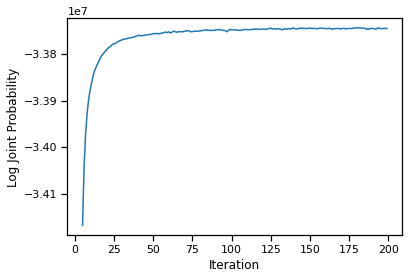

In [ ]:
offset = 5
plt.plot(torch.arange(offset, N_samples), samples["lps"][offset:])
plt.xlabel("Iteration")
plt.ylabel("Log Joint Probability")

Text(0.5, 0.98, 'Masked and Reconstructed Data')

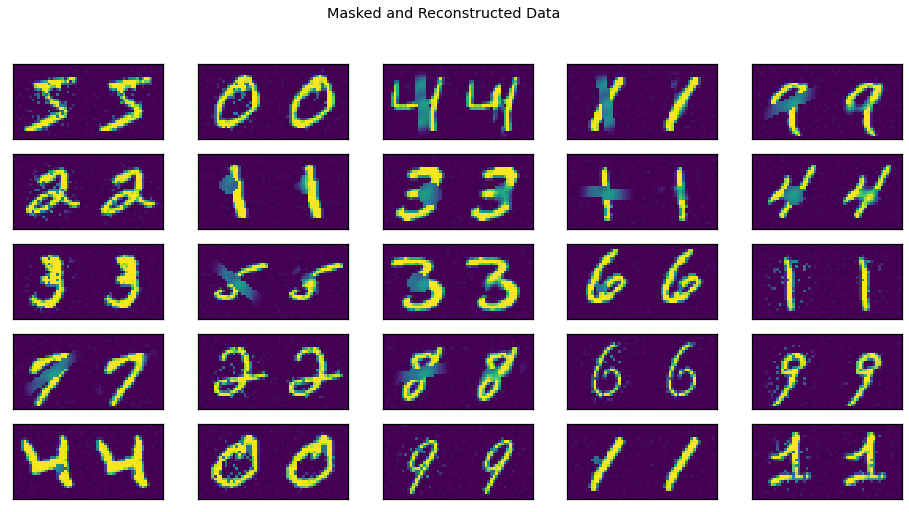

In [ ]:
# Plot the masked and reconstructed data, using the mean of X_miss samples
X_miss = samples['X_miss'][N_samples//2:].mean(dim=0)
X_recon = torch.clone(X)
X_recon[mask] = X_miss

# Plot a few masked data points
fig, axs = plt.subplots(5, 5, figsize=(16, 8))
for i in range(5):
    for j in range(5):
        im = torch.column_stack([X[i * 5 + j].reshape(28, 28),
                                 X_recon[i * 5 + j].reshape(28, 28)])
        axs[i, j].imshow(im, interpolation="none", vmin=0, vmax=255)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.suptitle("Masked and Reconstructed Data")

Text(0, 0.5, 'RMSE')

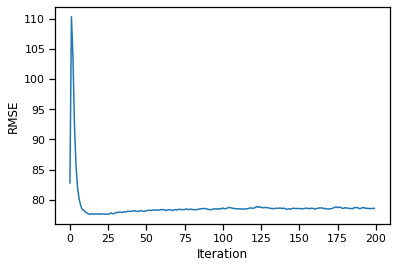

In [ ]:
# Plot the reconstruction error across Gibbs iterations
rmse = torch.sqrt(((samples['X_miss'] - X_true[mask])**2).mean(axis=1))
plt.plot(rmse)
plt.xlabel("Iteration")
plt.ylabel("RMSE")

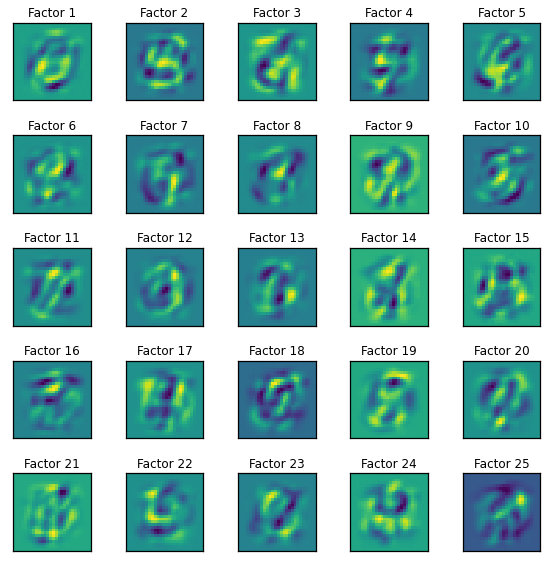

In [ ]:
# Plot the first 25 principal components
W = samples['W'][-1]
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(W[:, i * 5 + j].reshape((28, 28)), 
                        interpolation="none")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_title("Factor {}".format(i * 5 + j + 1))
plt.tight_layout()

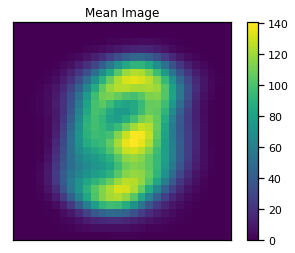

In [ ]:
# Plot the posterior mean of $\mu$
plt.imshow(samples["mu"][N_samples//2:].mean(dim=0).reshape(28, 28))
plt.xticks([])
plt.yticks([])
plt.title("Mean Image")
plt.colorbar()

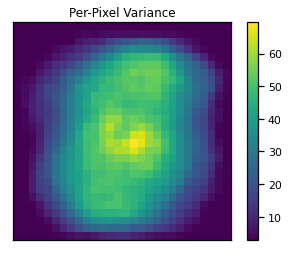

In [ ]:
# Plot the posterior mean of $\sigma^2$
plt.imshow(torch.sqrt(samples["sigmasq"][N_samples//2:])\
           .mean(0).reshape(28, 28))
plt.xticks([])
plt.yticks([])
plt.title("Per-Pixel Variance")
plt.colorbar()

## Problem 2d [Short answer]: Discussion

Were you surprised at how well (or poorly) you were able to reconstruct the masked images using factor analysis? Could you imagine alternative approaches that might perform better, and why?

---

I'd say that results turned out *decent* -- above, we see the successful unmasking of a handful of numbers, which is good? Moreover, the factors themselves appear to take semi-coherent, number-like/number-ish shapes, indicating some notion of learning (I'd be more worried if the factors were just large blobs). 

Further, the posterior mean $\mu$ appeared to take a number-ish shape as well, indicating some baseline contour on top of which the $ZW$ could construct. Similarly, the $\sigma$ vector, upon reshaping, was also activated most in the center regions, suggesting it was appropriately capturing where the action (i.e. the digits) was. Intuitively, there's minimal variance in the corners, because drawers usually leave that part of the paper/canvas untouched when drawing numbers.

Of course, this is not to declare total success. Some reconstructions had large blurs or smudges through them, where it appears that the model took a conservative guess over some portion, resulting in the blue (i.e. low intensity) smudge. 

To improve upon this, one might consider extending this method to include additional non-linearity: perhaps basis expansion occurs on each pixel or greater interactions are allowed between pixels (both of which probably increase computational cost greatly, however); alternatively, instead of a single linear $WZ$ factor decomposition, a handful of forward layers could be introduced to allow for additional non-linearity and interaction, e.g.

$$
g_H(\cdots g_2((g_1(ZW_1) + b_1)W_2 + b_2)\cdots + b_H).
$$

Of course, this may come at the cost of the Gibbs conditionals, so alternative algorithms for fitting/solving might have to be used.

---

# Bonus: The matrix normal distribution

In the model above, we put a prior on the weights $\mathbf{W} \in \mathbb{R}^{D \times M}$ by assuming each row to be an independent multivariate normal vector,
\begin{align}
p(\mathbf{W}) &= \prod_{d=1}^D \mathcal{N}(\mathbf{w}_d \mid \mathbf{0}, \tfrac{\sigma_d^2}{\kappa_0} \mathbf{I}).
\end{align}
However, in class we noted that it's a bit strange to put a prior on the rows when it's the columns (i.e. the principal components) that we really care about. 

For this bonus problem, we'll derive a **matrix normal** prior distribution instead. The matrix normal is a distribution on matrices $\mathbf{W} \in \mathbb{R}^{D \times M}$ with three parameters: a mean $\mathbf{M} \in \mathbb{R}^{D \times M}$, a positive definite covariance among the rows $\mathbf{\Sigma}_r \in \mathbb{R}_{\succeq 0}^{D \times D}$, and a positive definite covariance among the columns $\mathbf{\Sigma}_c \in \mathbb{R}_{\succeq 0}^{M \times M}$. 

The matrix normal distribution is equivalent to a multivariate distribution on the vectorized (aka flattened or raveled) matrix where the covariance matrix obeys a special, Kronecker-factored form. Specifically,
\begin{align}
\mathbf{W} \sim \mathcal{MN}(\mathbf{M}, \mathbf{\Sigma}_r, \mathbf{\Sigma}_c)
\iff \mathrm{vec}(\mathbf{W}) \sim \mathcal{N}(\mathrm{vec}(\mathbf{M}), \mathbf{\Sigma}_r \otimes \mathbf{\Sigma}_c),
\end{align}
where $\mathrm{vec}(\cdot)$ is the vectorization operation that ravels a matrix into a vector (here in row-major, i.e. C order) and $\otimes$ denotes the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product). 

For example, suppose
\begin{align}
\mathbf{M} = \begin{bmatrix} 1 & 2 \\ 3 & 4 \\ 5 & 6 \end{bmatrix}.
\end{align}
Then
\begin{align}
\mathrm{vec}\left( \mathbf{M} \right) = [1, 2, 3, 4, 5, 6]^\top.
\end{align}
The vectorized matrix is the concatenation of its rows.

To illustrate the Kronecker product, suppose
\begin{align}
    \mathbf{\Sigma}_r = \begin{bmatrix} 
    1 & 0 & 0 \\ 
    0 & 1 & 0 \\
    0 & 0 & 1 
    \end{bmatrix}, \quad
    \mathbf{\Sigma}_c = 
    \begin{bmatrix} 1 & -1 \\ -1 & 2 \end{bmatrix}
\end{align}
Then,
\begin{align}
    \mathbf{\Sigma}_r \otimes \mathbf{\Sigma}_c =
    \begin{bmatrix} 
    1 & -1 & 0 & 0 & 0 & 0\\ 
    -1 & 2 & 0 & 0 & 0 & 0\\
    0 & 0 & 1 & -1 & 0 & 0 \\
    0 & 0 & -1 & 2 & 0 & 0 \\
    0 & 0 & 0 & 0 & 1 & -1 \\
    0 & 0 & 0 & 0 & -1 & 2
    \end{bmatrix}
\end{align}
Since $\mathbf{\Sigma}_r$ is the identity matrix, each row $\mathbf{w}_d \in \mathbb{R}^2$ is an independent multivariate normal random variable with covariance $\mathbf{\Sigma}_c$. With this example in mind, we now see that the prior we used in Part 2 was really a special case of the matrix normal distribution with $\mathbf{M} = \mathbf{0}$, $\mathbf{\Sigma}_r = \mathrm{diag}([\sigma_1^2, \ldots, \sigma_D^2])$, and $\mathbf{\Sigma}_c = \kappa_0^{-1} \mathbf{I}$.

We can derive the matrix normal density by starting from the multivariate normal density on the vectorized matrix,
\begin{align}
p(\mathbf{W} \mid \mathbf{M}, \mathbf{\Sigma}_r, \mathbf{\Sigma}_c)
&= (2 \pi)^{-\frac{DM}{2}} |\mathbf{\Sigma}_r \otimes \mathbf{\Sigma}_c | 
\exp \left\{ -\frac{1}{2} \mathrm{vec}(\mathbf{W} - \mathbf{M})^\top (\mathbf{\Sigma}_r \otimes \mathbf{\Sigma}_c)^{-1} \mathrm{vec}(\mathbf{W} - \mathbf{M}) \right\} \\
&= (2 \pi)^{-\frac{DM}{2}} |\mathbf{\Sigma}_r|^M |\mathbf{\Sigma}_c|^D  
\exp \left\{ -\frac{1}{2} \mathrm{vec}(\mathbf{W} - \mathbf{M})^\top (\mathbf{\Sigma}_r^{-1} \otimes \mathbf{\Sigma}_c^{-1}) \mathrm{vec}(\mathbf{W} - \mathbf{M}) \right\} \\
&= (2 \pi)^{-\frac{DM}{2}} |\mathbf{\Sigma}_r|^M |\mathbf{\Sigma}_c|^D  
\exp \left\{ -\frac{1}{2} \mathrm{vec}(\mathbf{W} - \mathbf{M})^\top \mathrm{vec}(\mathbf{\Sigma}_r^{-1}(\mathbf{W} - \mathbf{M}) \mathbf{\Sigma}_c^{-1}) \right\} \\
&= (2 \pi)^{-\frac{DM}{2}} |\mathbf{\Sigma}_r|^M |\mathbf{\Sigma}_c|^D  
\exp \left\{ -\frac{1}{2}\mathrm{Tr} \left[ \mathbf{\Sigma}_c^{-1} (\mathbf{W} - \mathbf{M})^\top \mathbf{\Sigma}_r^{-1} (\mathbf{W} - \mathbf{M}) \right] \right\} \\
&\propto \exp \left\{ -\frac{1}{2}\mathrm{Tr} \left[ \mathbf{\Sigma}_c^{-1} \mathbf{W}^\top \mathbf{\Sigma}_r^{-1} \mathbf{W} \right] + \mathrm{Tr} \left[\mathbf{\Sigma}_c^{-1} \mathbf{M}^\top \mathbf{\Sigma}_r^{-1} \mathbf{W} \right] \right\}
\end{align}

_Note: the definitions given here are appropriate for Python/PyTorch, where vectorization is performed in row-major order. This is in contrast to the definition on [Wikipedia](https://en.wikipedia.org/wiki/Matrix_normal_distribution), which assumes column-major order, as in Matlab or R. The only difference is ther order of the Kronecker product is flipped._


## Bonus Problem [Math]: Derive the conditional distribution of the factor analysis weights under a matrix normal prior

Now consider the factor analysis model,
\begin{align}
\mathbf{z}_n &\sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\
\mathbf{x}_n &\sim \mathcal{N}(\mathbf{W} \mathbf{z}_n + \boldsymbol{\mu}, \mathrm{diag}(\boldsymbol{\sigma}^2))
\end{align}
where $\boldsymbol{\mu} = [\mu_1, \ldots, \mu_D]^\top$ and $\boldsymbol{\sigma}^2 = [\sigma_1^2, \ldots, \sigma_D^2]^\top$. 

Suppose we put the following matrix normal prior on the weights and variances,
\begin{align}
\sigma_d^2 &\sim \chi^{-2}(\nu_0, \sigma_0^2) \\
\boldsymbol{\mu} &\sim \mathcal{N}(\mathbf{0}, \mathrm{diag}(\boldsymbol{\sigma}^2) / \lambda_0) \\
\mathbf{W} &\sim \mathcal{MN}(\mathbf{0}, \mathrm{diag}(\boldsymbol{\sigma}^2), \mathbf{\Sigma}_c)
\end{align}
where $\mathbf{\Sigma}_c$ is the prior covariance among the columns.

Derive the complete conditional distribution of the weights,
\begin{align}
p(\mathbf{W} \mid \{\mathbf{z}_n, \mathbf{x}_n\}_{n=1}^N, \boldsymbol{\mu}, \boldsymbol{\sigma}^2, \mathbf{\Sigma}_c) 
\end{align}

Finally, let $\mathbf{\Sigma}_c^{-1} \to \mathbf{0}$. What does the conditional mean of $\mathbf{W}$ converge to? Does this expression look familiar?

---

Dropping constants and using shorthand $\Sigma_\sigma: = diag(\sigma^2)$ and $\tilde x_n = x_n - \mu$, we have
\begin{align*}
p(W | -)
&
\propto 
\mathcal{L}(\cdot) \\
&\propto 
\bigg(
\prod_{n=1}^N \mathcal{N}(x_n | Wz_n + \mu, \Sigma_\sigma)
\bigg) \cdot \mathcal{MN}(W | 0, \Sigma_\sigma, \Sigma_c) \\
&\propto 
\exp\bigg(
-\frac{1}{2}
\bigg[ 
\sum_{n=1}^N (x_n - \mu - Wz_n)^T\Sigma_\sigma^{-1}(x_n - \mu - Wz_n)
\bigg]
\bigg)\cdot \\ &\hspace{1.5cm}
\exp\bigg(
-\frac{1}{2}tr\{\Sigma_c^{-1}W^T\Sigma_\sigma^{-1}W\} +
  \frac{1}{2}tr\{\Sigma_c^{-1}M^T\Sigma_\sigma^{-1}W\}
\bigg) \\
&\propto 
\exp\bigg(
-\frac{1}{2}
\bigg[ 
\sum_{n=1}^N (\tilde x_n - Wz_n)^T\Sigma_\sigma^{-1}(\tilde x_n - Wz_n)
\bigg]
\bigg)\cdot \\ &\hspace{1.5cm}
\exp\bigg(
-\frac{1}{2}tr\{\Sigma_c^{-1}W^T\Sigma_\sigma^{-1}W\} +
  \frac{1}{2}tr\{\Sigma_c^{-1}M^T\Sigma_\sigma^{-1}W\}
\bigg) \\
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
&\propto 
\exp\bigg(
-\frac{1}{2}
\sum_{n=1}^N z_n^TW^T\Sigma_\sigma^{-1}Wz_n 
+ \sum_{n=1}^N \tilde x_n^T\Sigma_\sigma^{-1}Wz_n
\bigg)\cdot \\ &\hspace{1.5cm}
\exp\bigg(
-\frac{1}{2}tr\{\Sigma_c^{-1}W^T\Sigma_\sigma^{-1}W\} +
  tr\{\Sigma_c^{-1}M^T\Sigma_\sigma^{-1}W\}
\bigg)\\
&\propto 
\exp\bigg(
-\frac{1}{2}
tr\{\sum_{n=1}^N z_nz_n^T W^T\Sigma_\sigma^{-1}W\}
+ tr\{\sum_{n=1}^N \tilde x_n^T\Sigma_\sigma^{-1}Wz_n\}
\bigg)\cdot \\ &\hspace{1.5cm}
\exp\bigg(
-\frac{1}{2}tr\{\Sigma_c^{-1}W^T\Sigma_\sigma^{-1}W\} +
  tr\{\Sigma_c^{-1}M^T\Sigma_\sigma^{-1}W\}
\bigg)\\
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
&\propto 
\exp\bigg(
-\frac{1}{2}
tr\{Z^TZW^T\Sigma_\sigma^{-1}W\}
+ tr\{\sum_{n=1}^N \tilde x_n^T\Sigma_\sigma^{-1}Wz_n\}
\bigg)\cdot \\ &\hspace{1.5cm}
\exp\bigg(
-\frac{1}{2}tr\{\Sigma_c^{-1}W^T\Sigma_\sigma^{-1}W\} +
  tr\{\Sigma_c^{-1}M^T\Sigma_\sigma^{-1}W\}
\bigg)\\
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
&\propto 
\exp\bigg(
-\frac{1}{2}
tr\{Z^TZW^T\Sigma_\sigma^{-1}W\}
+ tr\{\tilde X \Sigma_\sigma^{-1}WZ^T\}
\bigg)\cdot \\ &\hspace{1.5cm}
\exp\bigg(
-\frac{1}{2}tr\{\Sigma_c^{-1}W^T\Sigma_\sigma^{-1}W\} +
  tr\{\Sigma_c^{-1}M^T\Sigma_\sigma^{-1}W\}
\bigg)\\
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
&\propto 
\exp\bigg(
-\frac{1}{2}
tr\{Z^TZW^T\Sigma_\sigma^{-1}W\}
+ tr\{Z^T\tilde X \Sigma_\sigma^{-1}W\}
\bigg)\cdot \\ &\hspace{1.5cm}
\exp\bigg(
-\frac{1}{2}tr\{\Sigma_c^{-1}W^T\Sigma_\sigma^{-1}W\} +
  tr\{\Sigma_c^{-1}M^T\Sigma_\sigma^{-1}W\}
\bigg)\\
%**********************************
&\propto 
\exp\bigg(
-\frac{1}{2}
tr\{Z^TZW^T\Sigma_\sigma^{-1}W + \Sigma_c^{-1}W^T\Sigma_\sigma^{-1}W\}\\
&\hspace{1.5cm}
+ tr\{Z^T\tilde X \Sigma_\sigma^{-1}W + \Sigma_c^{-1}M^T\Sigma_\sigma^{-1}W\}
\bigg)\\
%**********************************
&\propto 
\exp\bigg(
-\frac{1}{2}
tr\{(Z^TZ + \Sigma_c^{-1})W^T\Sigma_\sigma^{-1}W\}\\
&\hspace{1.5cm}
+ tr\{(Z^T\tilde X  + \Sigma_c^{-1}M^T)\Sigma_\sigma^{-1}W\}
\bigg).
\end{align*}
Hence, the posterior is 
$$
W|- \sim 
\mathcal{MN}\bigg(Z^T\tilde X  + \Sigma_c^{-1}M^T; \Sigma_\sigma; Z^TZ + \Sigma_c^{-1}\bigg).
$$

For algebraic justification, pretty much all of the above steps were justified by the following properties of the trace:

* For $A, B \in \mathbb{R}^{n\times n},$ we have $tr(A+B) = tr(A) + tr(B)

* For $A, B$ s.t. $AB \in \mathbb{R}^{n\times n}$, then $tr(AB) = tr(BA)$.

* For $A, B, C$ st. $ABC \in \mathbb{R}^{n\times n}$, then $tr(ABC) = tr(BCA) = tr(CAB)$.

---

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and remove the Open in Colab button.  Then run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf <yourname>_hw3.ipynb
```

**Installing nbconvert:**

If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

If you can't get `nbconvert` to work, you may print to PDF using your browswer, but please make sure that none of your code, text, or math is cut off.

**Upload** your .pdf files to Gradescope. 